# Predicting House Prices by Multiple Regression with Gradient Descent

In this notebook, I will still use data on house sales in King County, where Seattle is located, to predict house prices by using **multiple regression with gradient descent algorithm**. We have applied multiple regression by using closed form in [Multiple_Regression_Closed_Form.ipynb
](https://github.com/hsuanhao/Projects/blob/master/Predicting%20house%20pricing%20in%20Seattle/Multiple_Regression_Closed_Form.ipynb). However, this method involves computing $({\bf X}^T {\bf X})^{-1}$, where $\bf X$ is $N$ by $(D+1)$ matrix. Here $N$ is number of samples and $D$ is the number of features. The total complexity of computing $({\bf X}^T {\bf X})^{-1}$ is ${\cal O}(ND^2 + D^3)$. Hence, if $D$ is large, the method costs lots of computing time. Instead, we adopt **gradient descent algorithm**, more efficient way, in this notebook. 

In [1]:
# Import libraries to use
import numpy as np
import pandas as pd
#import os
#from sklearn.model_selection import train_test_split
import Regression
from FeatureProcessing import get_numpy_data

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

/home/eckhard/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. Load in House Sales Data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
# Load the data
sales_train = pd.read_csv("dataset/kc_house_train_data.csv", dtype = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}
)
sales_test = pd.read_csv("dataset/kc_house_test_data.csv", dtype = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}
)
display(sales_train.T)

,0,1,2,3,4,5,6,7,8,9,...,17374,17375,17376,17377,17378,17379,17380,17381,17382,17383
id,7129300520,6414100192,5631500400,2487200875,1954400510,7237550310,1321400060,2008000270,2414600126,3793500160,...,0249000205,5100403806,0844000965,7852140040,9834201367,7936000429,2997800021,0263000018,0291310100,1523300157
date,20141013T000000,20141209T000000,20150225T000000,20141209T000000,20150218T000000,20140512T000000,20140627T000000,20150115T000000,20150415T000000,20150312T000000,...,20141015T000000,20150407T000000,20140626T000000,20140825T000000,20150126T000000,20150326T000000,20150219T000000,20140521T000000,20150116T000000,20141015T000000
price,221900,538000,180000,604000,510000,1.225e+06,257500,291850,229500,323000,...,1.537e+06,467000,224000,507250,429000,1.0075e+06,475000,360000,400000,325000
bedrooms,3,3,2,4,3,4,3,3,3,3,...,5,3,3,3,3,4,3,3,3,2
bathrooms,1,2.25,1,3,2,4.5,2.25,1.5,1,2.5,...,3.75,2.5,1.75,2.5,2,3.5,2.5,2.5,2.5,0.75
sqft_living,1180,2570,770,1960,1680,5420,1715,1060,1780,1890,...,4470,1425,1500,2270,1490,3510,1310,1530,1600,1020
sqft_lot,5650,7242,10000,5000,8080,101930,6819,9711,7470,6560,...,8088,1179,11968,5536,1126,7200,1294,1131,2388,1076
floors,1,2,1,1,1,1,2,1,1,2,...,2,3,1,2,3,2,2,3,2,2
waterfront,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
view,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print('kc_house_train_data.csv has {} training samples, \
and kc_house_test_data.csv has {} test samples'.format(sales_train['id'].count(), sales_test['id'].count()))

kc_house_train_data.csv has 17384 training samples, and kc_house_test_data.csv has 4229 test samples


## 2. Simple Linear Regression

Since I coded for linear regression model from scratch by using Tensorflow framework, it is better to compare the results with known results obtained from simple liner regression by closed form in [Simple_Linear_Regression.ipynb
](https://github.com/hsuanhao/Projects/blob/master/Predicting%20house%20pricing%20in%20Seattle/Simple_Linear_Regression.ipynb).

### Convert DataFrames into Numpy Arrays

Although Pandas offers a number of benefits to users, in order to understand the details of the implementation of algorithms it's important to work with a library that allows for direct (and optimized) matrix operations. Numpy is a Python solution to work with matrices (or any multi-dimensional "array").

Recall that the predicted value given the weights and the features is just the dot product between the feature and weight vector. Similarly, if we put all of the features row-by-row in a matrix then the predicted value for all the observations can be computed by right multiplying the "feature matrix" by the "weight vector".

First, we need to take the DataFrames of our data and convert it into a 2D numpy array (also called a matrix). To do this, I use the function, `get_numpy_data`, in FeatureProcessing library coded by myself. 


In [4]:
# Convert dataframe into numpy array
simple_features = ['sqft_living']
my_output = 'price'

X_train, Y_train = get_numpy_data(sales_train, simple_features, my_output)
X_test, Y_test = get_numpy_data(sales_test, simple_features, my_output)

In [5]:
# Rescale price by 1e5 and sqft-living by 1e3
X_train = X_train/1000.0
X_test = X_test/1000.0
Y_train = Y_train/100000.0
Y_test = Y_test/100000.0

### Running the Gradient Descent as Simple Linear Regression

In [6]:
# Calculate linear regression parameters by gradient descent

# Create an object
model_simple = Regression.LinearRegression()

Cost after epoch 0: 42.758007
Cost after epoch 100: 35.133405
Cost after epoch 200: 29.144602
Cost after epoch 300: 24.440570
Cost after epoch 400: 20.745612
Cost after epoch 500: 17.843189
Cost after epoch 600: 15.563233
Cost after epoch 700: 13.772170
Cost after epoch 800: 12.365089
Cost after epoch 900: 11.259592
Cost after epoch 1000: 10.390966
Cost after epoch 1100: 9.708380
Cost after epoch 1200: 9.171915
Cost after epoch 1300: 8.750216
Cost after epoch 1400: 8.418658
Cost after epoch 1500: 8.157898
Cost after epoch 1600: 7.952746
Cost after epoch 1700: 7.791271
Cost after epoch 1800: 7.664103
Cost after epoch 1900: 7.563881
Cost after epoch 2000: 7.484824
Cost after epoch 2100: 7.422393
Cost after epoch 2200: 7.373022
Cost after epoch 2300: 7.333911
Cost after epoch 2400: 7.302859
Cost after epoch 2500: 7.278138
Cost after epoch 2600: 7.258393
Cost after epoch 2700: 7.242557
Cost after epoch 2800: 7.229794
Cost after epoch 2900: 7.219445
Cost after epoch 3000: 7.210994
Cost afte

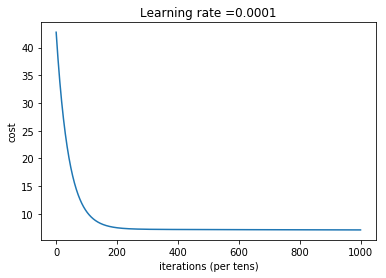

Parameters have been trained!


In [7]:
parameters_simple = model_simple.fit(X_train, Y_train, learning_rate = 0.0001, num_epochs = 10000, minibatch_size=17384, print_cost = True)

In [8]:
print(parameters_simple)

{'W': array([[2.38390916]]), 'b': array([[0.58345497]])}


### Test Simple Linear Regression Algorithm

Use your newly estimated weights to compute the predictions on all the TEST data:

In [9]:
# By using fitting parameters we obtained, predict house price with given example features
predictions_simple_test = model_simple.predict(X_test, parameters_simple)

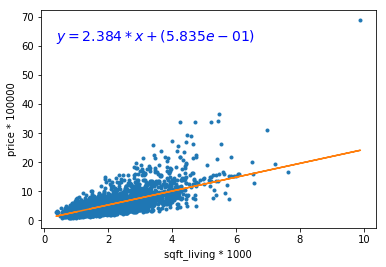

In [12]:
# Visualize the fitting line on TEST data
model_simple.plot(X_test, Y_test, predictions_simple_test, parameters_simple, xlabel='sqft_living * 1000', ylabel='price * 100000')

In [13]:
# Evaluate model by RSS
RSS1 = model_simple.scores(Y_test, predictions_simple_test)*(1e10)
print("RSS when using simple feature on TEST data = %1.3e" % RSS1)

RSS when using simple feature on TEST data = 2.803e+14


The RSS we obtained is close to the one obtained from simple linear regression. Note that since we rescale the price values by $10^5$,

$$ y_{\rm new} = \frac{y_{\rm old}}{10^5}.$$

Hence, if one wants to get the price in dollars, then one has to multiply $10^5$. That is, $y_{\rm old} = 10^5 * y_{\rm new}$. Similarly, the RSS involve $y^2$ so there is factor $10^{10}$.

## 3. Multiple Regression

Now we will use more than one actual feature for our second model.

In [14]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'

X_train, Y_train = get_numpy_data(sales_train, model_features, my_output)
X_test, Y_test = get_numpy_data(sales_test, model_features, my_output)

In [15]:
# Rescale price by 1e5 and sqft-living by 1e3
X_train = X_train/1000.0
X_test = X_test/1000.0
Y_train = Y_train/100000.0
Y_test = Y_test/100000.0

In [16]:
# Calculate linear regression parameters by gradient descent

# Create an object
model_2 = Regression.LinearRegression()

Cost after epoch 0: 42.758007
Cost after epoch 100: 30.845654
Cost after epoch 200: 22.960182
Cost after epoch 300: 17.739737
Cost after epoch 400: 14.283038
Cost after epoch 500: 11.993609
Cost after epoch 600: 10.476701
Cost after epoch 700: 9.471065
Cost after epoch 800: 8.803806
Cost after epoch 900: 8.360499
Cost after epoch 1000: 8.065420
Cost after epoch 1100: 7.868451
Cost after epoch 1200: 7.736425
Cost after epoch 1300: 7.647392
Cost after epoch 1400: 7.586824
Cost after epoch 1500: 7.545109
Cost after epoch 1600: 7.515881
Cost after epoch 1700: 7.494932
Cost after epoch 1800: 7.479473
Cost after epoch 1900: 7.467660
Cost after epoch 2000: 7.458272
Cost after epoch 2100: 7.450502
Cost after epoch 2200: 7.443814
Cost after epoch 2300: 7.437854
Cost after epoch 2400: 7.432389
Cost after epoch 2500: 7.427261
Cost after epoch 2600: 7.422370
Cost after epoch 2700: 7.417646
Cost after epoch 2800: 7.413045
Cost after epoch 2900: 7.408536
Cost after epoch 3000: 7.404099
Cost after ep

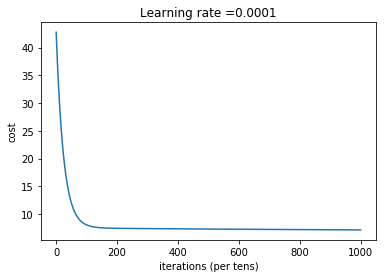

Parameters have been trained!


In [17]:
parameters_2 = model_2.fit(X_train, Y_train, learning_rate = 0.0001, num_epochs = 10000, minibatch_size=17384, print_cost = True)

### Test Multiple Regression Algorithm

Use your newly estimated weights to compute the predictions on all the TEST data:

In [18]:
# By using fitting parameters we obtained, predict house price with given example features
predictions_2_test = model_2.predict(X_test, parameters_2)

In [20]:
# Evaluate model by RSS
RSS2 = model_2.scores(Y_test, predictions_2_test)*(1e10)
print("RSS when using multiple features on TEST data = %1.3e" % RSS2)

RSS when using multiple features on TEST data = 2.799e+14


## 4. Discussion

 **What is the predicted price for the 1st house in the TEST data set for model 1 and 2 (round to nearest dollar)?**

In [27]:
# For model 1 (simple linear regression)
price_1 = int(np.squeeze(predictions_simple_test[0])*100000)
print('For model 1, the predicted price for the 1st house in the TEST data set is ${}'.format(price_1))

For model 1, the predicted price for the 1st house in the TEST data set is $399244


In [26]:
# For model 2 (multiple regression)
price_2 = int(np.squeeze(predictions_2_test[0])*100000)
print('For model 2, the predicted price for the 1st house in the TEST data set is ${}'.format(price_2))

For model 2, the predicted price for the 1st house in the TEST data set is $426036


In [28]:
# The actual price for the 1st house in the test data set
actual_price = int(np.squeeze(Y_test[0])*100000)
print('The actual price for the 1st house in the test data set is ${}'.format(actual_price))

The actual price for the 1st house in the test data set is $310000


When we only examine one specific sample (price for the 1st house in the test data set), it seems that model 1 (simple linear regression) predict more accurate than model 2 (multiple regression). However, this is only the case of specific case. In order to evaluate the performance of two models, we have to consider RSS in the following. 

**Which model (1 or 2) has lowest RSS on all of the TEST data?** 

In [29]:
print("RSS when using simple feature on TEST data = %1.3e" % RSS1)
print("RSS when using multiple features on TEST data = %1.3e" % RSS2)

RSS when using simple feature on TEST data = 2.803e+14
RSS when using multiple features on TEST data = 2.799e+14


From above results, **model 2 (multiple regression) has lowest RSS on all of the TEST data**.